In [1]:
# Author Dmitry Ermilov
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import imageio
from skimage import color

def compress(image, k=2):
    n, m = image.shape[:2]
    n_k = n // k
    m_k = m // k
    new_image = np.zeros_like(image)[:n_k, :m_k]
    for i in range(n_k):
        for j in range(m_k):
            new_image[i, j] = np.mean(image[k*i:k*(i+1), k*j:k*(j+1)].reshape(k**2, -1), axis=0)
    return new_image

def indices_to_disp_matrix(image_shape, disp_rl, disp_lr):
    matrix_1 = np.zeros(image_shape)
    matrix_2 = np.zeros(image_shape)
    for disp_local in disp_rl:
        i10, i1N, i20, i2M, j10, j1N, j20, j2M = disp_local 
        matrix_1[i10:i1N, i20:i2M] = j10 - i10
        matrix_2[i10:i1N, i20:i2M] = j20 - i20
    for disp_local in disp_lr:
        i10, i1N, i20, i2M, j10, j1N, j20, j2M = disp_local
        matrix_1[j10:j1N, j20:j2M] = i10 - j10
        matrix_2[j10:j1N, j20:j2M] = i20 - j20
    return matrix_1, matrix_2

def findRectengular(image_shape, disp, sh):
    l2, l1, r2, r1 = disp
    N, M = image_shape
    sha = np.array([[-l1+sh, l1+sh-N, -l2+sh, l2+sh-M], 
                    [-r1+sh, r1+sh-N, -r2+sh, r2+sh-M], 
                    [0,      0,       0,      0      ]], np.int32).max(axis=0)
    return l1-sh+sha[0], l1+sh-sha[1], l2-sh+sha[2], l2+sh-sha[3], \
           r1-sh+sha[0], r1+sh-sha[1], r2-sh+sha[2], r2+sh-sha[3]  

def correctDisparity(imageL, imageR, disp, sh, sh_it):
#     print("In", disp)
    l2, l1, r2, r1 = disp
    N, M = imageL.shape[:2]
    d_min = 1000
    r10 = np.max((r1 - sh_it, 0))
    r1N = np.min((r1 + sh_it, N))
    r20 = np.max((r2 - sh_it, 0))
#     print(r2, M)
    r2M = np.min((r2 + sh_it, M))
#     print(r2 + sh_it)
#     p_min = None
    
    for p1 in range(r10, r1N):
        for p2 in range(r20, r2M):
            i10, i1N, i20, i2M, j10, j1N, j20, j2M = findRectengular(imageL.shape[:2], (l2, l1, p2, p1), sh)
            if i1N - i10 == 0  or i2M - i20 == 0:
#                 print("Continue")
                continue
            imgL_local = imageL[i10:i1N, i20:i2M]
            imgR_local = imageR[j10:j1N, j20:j2M]
            d_local = np.abs(imgL_local - imgR_local).mean()
#             print(d_min, d_local, p_min)
            if d_local < d_min:
                d_min = d_local
                p_min = i10, i1N, i20, i2M, j10, j1N, j20, j2M
#     print("Out", r10, r1N, r20, r2M, sh_it)
    return p_min, d_min

In [3]:
def step(filename, dispfilename, threshold=2, init=False):
    imgL = imageio.imread(filename+"l.png")
    imgR = imageio.imread(filename+"r.png")
    disparity_lr = np.int32(np.loadtxt(dispfilename+"_output_lr.txt")[:, :4])
    disparity_rl = np.int32(np.loadtxt(dispfilename+"_output_rl.txt")[:, :4])
    if init:
        imgL = compress(imgL)
        imgR = compress(imgR)
        disparity_lr = disparity_lr // 2
        disparity_rl = disparity_rl // 2
        
    imgL_hsv = matplotlib.colors.rgb_to_hsv(imgL)
    imgR_hsv = matplotlib.colors.rgb_to_hsv(imgR)
    
    sh_it = 4
    shift_list = [4, 3, 2, 1]

    disp_rl = []
    diff = np.empty(disparity_rl.shape[0])
    disp = np.empty((disparity_rl.shape[0], 8), np.int32)
    used_indices = np.zeros(disparity_rl.shape[0], dtype=np.bool_)
    print("Right to Left")
    for sh in shift_list:
        for i, disparity_local in enumerate(disparity_rl):
            disp[i], diff[i] = correctDisparity(imgR_hsv, imgL_hsv, disparity_local, sh, sh_it)
        indices_local = diff < threshold
        indices_local[used_indices] = False
        disp_rl.append(np.array(disp[indices_local]))
        used_indices[indices_local] = True
    disp_rl = np.vstack(disp_rl)

    disp_lr = []
    diff = np.empty(disparity_lr.shape[0])
    disp = np.empty((disparity_lr.shape[0], 8), np.int32)
    used_indices = np.zeros(disparity_lr.shape[0], dtype=np.bool_)
    print("Left to Right")
    for sh in shift_list:
        for i, disparity_local in enumerate(disparity_lr):
            disp[i], diff[i] = correctDisparity(imgL_hsv, imgR_hsv, disparity_local, sh, sh_it)
        indices_local = diff < threshold
        indices_local[used_indices] = False
        disp_lr.append(np.array(disp[indices_local]))
        used_indices[indices_local] = True
    disp_lr = np.vstack(disp_lr)
    
    newR =np.zeros_like(imgR)
    for disp_local in disp_rl:
        i10, i1N, i20, i2M, j10, j1N, j20, j2M = disp_local
        newR[i10:i1N, i20:i2M] = imgL[j10:j1N, j20:j2M]

    for disp_local in disp_lr:
        i10, i1N, i20, i2M, j10, j1N, j20, j2M = disp_local
        newR[j10:j1N, j20:j2M] = imgL[i10:i1N, i20:i2M]
    plt.figure(figsize=(10, 18))
    plt.subplot(311)
    plt.title("Left")
    plt.imshow(imgL)
    plt.subplot(312)
    plt.title("Reconstructed Right")
    plt.imshow(color.rgb2gray(imgR), cmap="gray")
    plt.imshow(newR, alpha=0.5)
    plt.subplot(313)
    plt.title("Right")
    plt.imshow(imgR)
    plt.show()
    
    return indices_to_disp_matrix(imgL.shape[:2], disp_rl, disp_lr)

Right to Left
Left to Right


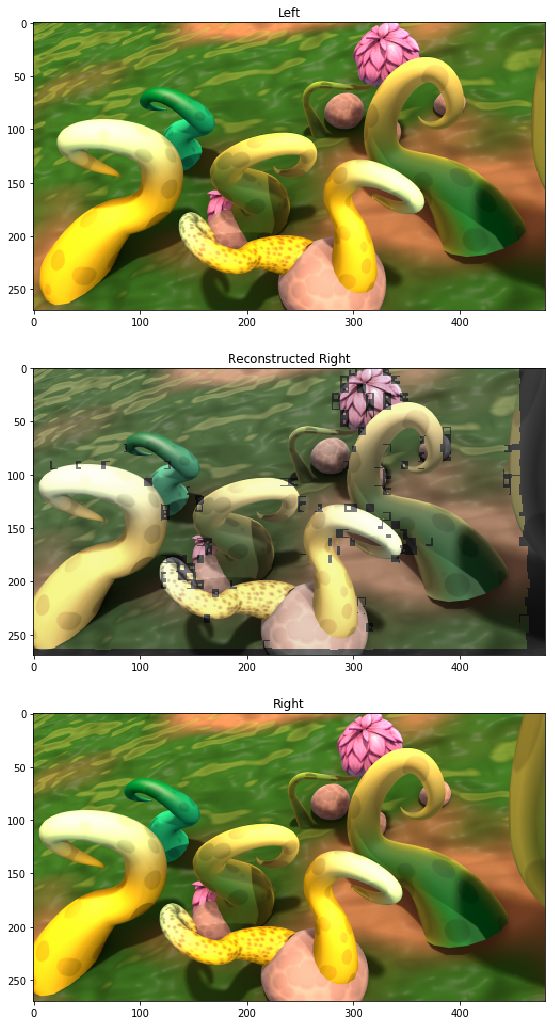

In [4]:
mh_init, mv_init = step("0134", "init", init=True)

In [2]:
!~/cloud/deepmatching_1.2.2_c++/deepmatching abst_baseline134_l.png abst_baseline134_r.png -nt 6 -out abst_output_lr.txt
!~/cloud/deepmatching_1.2.2_c++/deepmatching abst_baseline134_r.png abst_baseline134_l.png -nt 6 -out abst_output_rl.txt

Right to Left
Left to Right


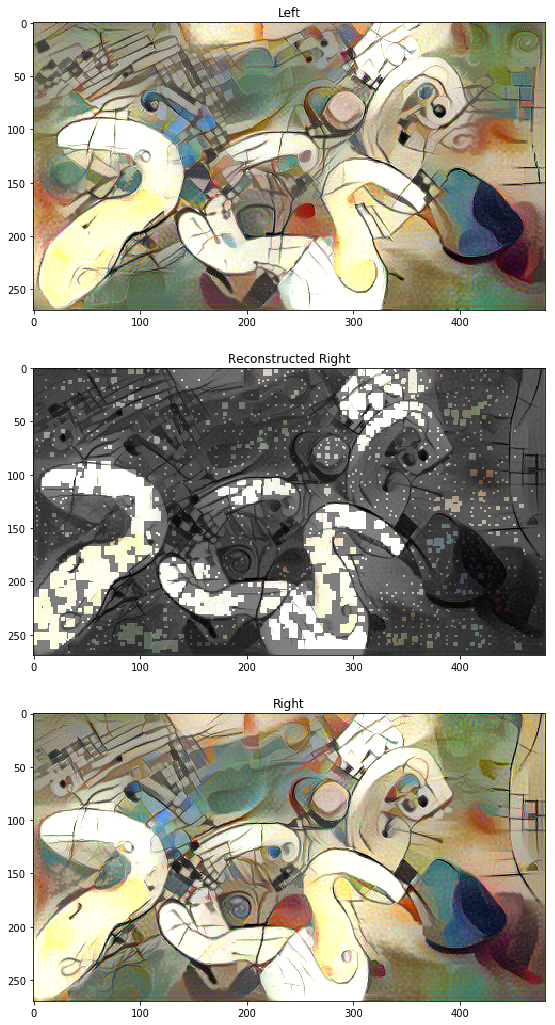

In [5]:
mh_styled, mv_styled = step("abst_baseline134_", "abst")

In [6]:
np.linalg.norm(mh_styled - mh_init), np.linalg.norm(mv_styled - mv_init)

(586.4187923318965, 4546.676148572713)

In [7]:
!~/cloud/deepmatching_1.2.2_c++/deepmatching abst_opencv_134_l.png abst_opencv_134_r.png -nt 6 -out opencv_output_lr.txt
!~/cloud/deepmatching_1.2.2_c++/deepmatching abst_opencv_134_r.png abst_opencv_134_l.png -nt 6 -out opencv_output_rl.txt

Right to Left
Left to Right


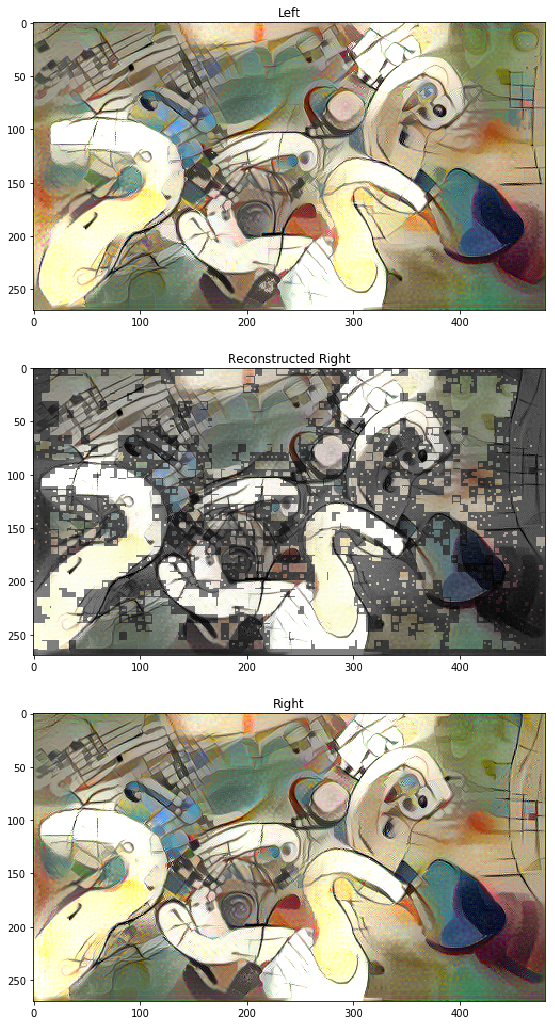

(411.0048661512416, 3323.445200390703)

In [8]:
mh_styled, mv_styled = step("abst_opencv_134_", "opencv")
np.linalg.norm(mh_styled - mh_init), np.linalg.norm(mv_styled - mv_init)

In [10]:
!~/cloud/deepmatching_1.2.2_c++/deepmatching abst_deep_134_l.png abst_deep_134_r.png -nt 6 -out deep_output_lr.txt
!~/cloud/deepmatching_1.2.2_c++/deepmatching abst_deep_134_r.png abst_deep_134_l.png -nt 6 -out deep_output_rl.txt

Right to Left
Left to Right


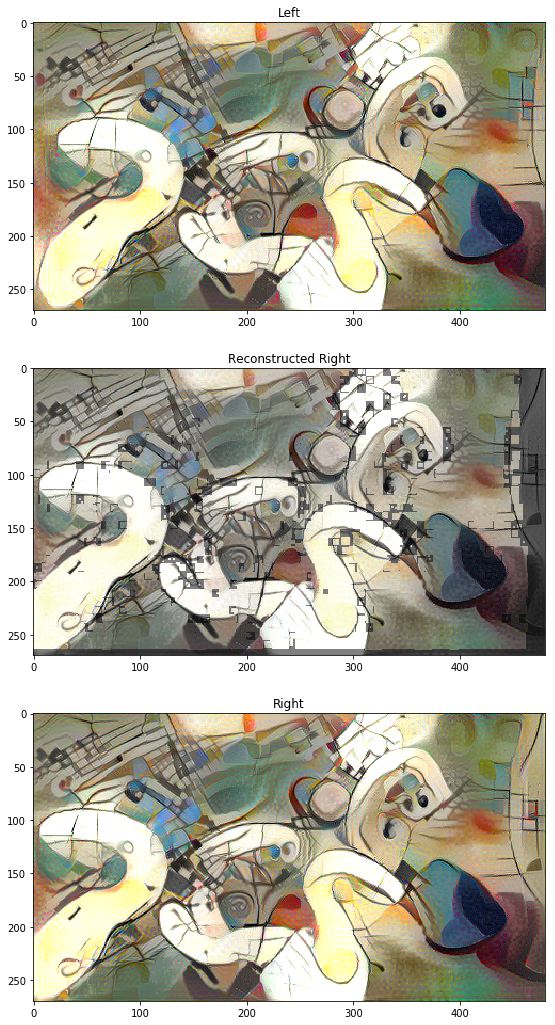

(234.3266950221421, 1226.2809629118442)

In [11]:
mh_styled, mv_styled = step("abst_deep_134_", "deep")
np.linalg.norm(mh_styled - mh_init), np.linalg.norm(mv_styled - mv_init)

In [14]:
!~/cloud/deepmatching_1.2.2_c++/deepmatching abst_dispnet_134_l.png abst_dispnet_134_r.png -nt 6 -out dispnet_output_lr.txt
!~/cloud/deepmatching_1.2.2_c++/deepmatching abst_dispnet_134_r.png abst_dispnet_134_l.png -nt 6 -out dispnet_output_rl.txt

Right to Left
Left to Right


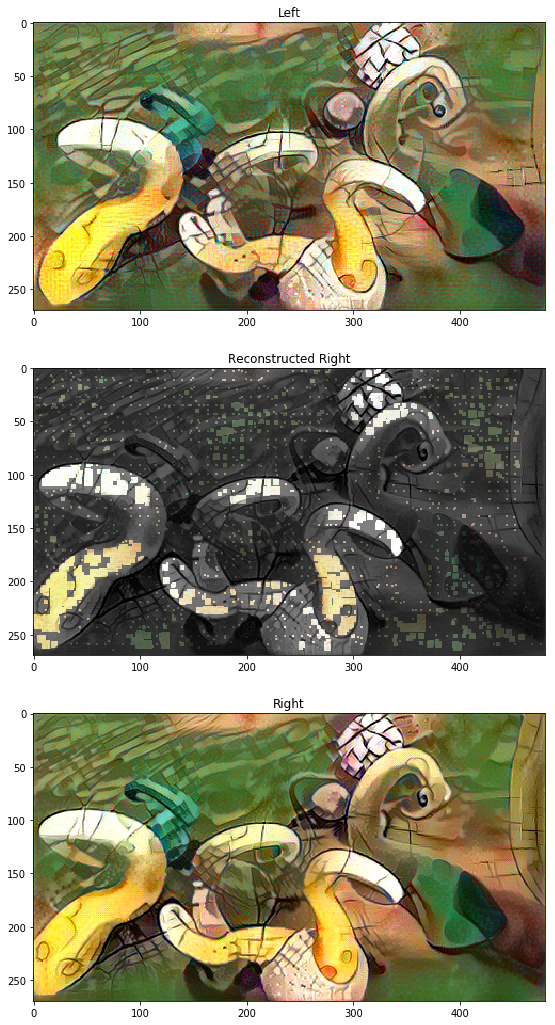

(421.0035629302916, 4716.093616543251)

In [15]:
mh_styled, mv_styled = step("abst_dispnet_134_", "dispnet")
np.linalg.norm(mh_styled - mh_init), np.linalg.norm(mv_styled - mv_init)

In [16]:
!~/cloud/deepmatching_1.2.2_c++/deepmatching abst_truth_134_l.png abst_truth_134_r.png -nt 6 -out truth_output_lr.txt
!~/cloud/deepmatching_1.2.2_c++/deepmatching abst_truth_134_r.png abst_truth_134_l.png -nt 6 -out truth_output_rl.txt

Right to Left
Left to Right


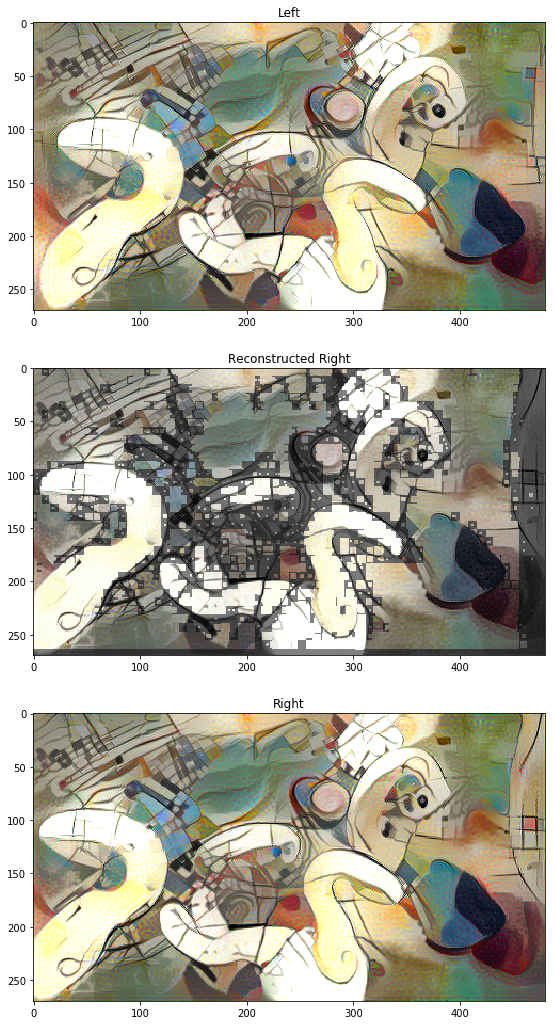

(326.2943456451552, 2688.39989584883)

In [17]:
mh_styled, mv_styled = step("abst_truth_134_", "truth")
np.linalg.norm(mh_styled - mh_init), np.linalg.norm(mv_styled - mv_init)